# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse NAc cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [2]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [5]:
import os
import urllib.request
import gzip
import shutil

url_list=[r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Fmatrix%2Emtx%2Egz"]

def download_file(url, dir, file_name):
    full_path = os.path.join(dir, file_name)
    urllib.request.urlretrieve(url, full_path)

    # gzファイルを解凍
    #with gzip.open(full_path, 'rb') as f_in:
    #    with open(full_path[:-3], 'wb') as f_out:
    #        shutil.copyfileobj(f_in, f_out)

dir = "/temp/data/mouse_NAc/"

for url in url_list:
    acc = url.split("acc=")[1].split("&")[0]
    file_name_from_url = url.split("file=")[1]

    # 対応するGSMXXXXXフォルダを作成
    acc_dir = os.path.join(dir, acc)
    os.makedirs(acc_dir, exist_ok=True)

     # 標準的なファイル名に変更（.gzを取り除く）
    standard_file_name = file_name_from_url.split('_')[-1].replace('.gz', '')
    
    if "barcodes" in file_name_from_url:
        standard_file_name = "barcodes.tsv.gz"
    elif "features" in file_name_from_url:
        standard_file_name = "features.tsv.gz"
    elif "matrix" in file_name_from_url:
        standard_file_name = "matrix.mtx.gz"
    
    # ファイルをダウンロードして解凍
    download_file(url, acc_dir, standard_file_name)


## load data

In [3]:
dir="/temp/data/mouse_NAc/"
adata = sc.read_10x_mtx(os.path.join(dir,"GSM5482106"))
print(adata.X.shape)

(737280, 31053)


In [4]:
adata2 = sc.read_10x_mtx(os.path.join(dir,"GSM5482107"))
print(adata2.X.shape)

(737280, 31053)


In [5]:
adata=anndata.concat([adata,adata2])
adata.obs_names_make_unique
del adata2

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [13]:
print(adata.obs_names)
print(adata.var_names)

Index(['AAACCTGAGAAACCAT-1', 'AAACCTGAGAAACCGC-1', 'AAACCTGAGAAACCTA-1',
       'AAACCTGAGAAACGAG-1', 'AAACCTGAGAAACGCC-1', 'AAACCTGAGAAAGTGG-1',
       'AAACCTGAGAACAACT-1', 'AAACCTGAGAACAATC-1', 'AAACCTGAGAACTCGG-1',
       'AAACCTGAGAACTGTA-1',
       ...
       'TTTGTCATCTTGGGTA-1', 'TTTGTCATCTTGTACT-1', 'TTTGTCATCTTGTATC-1',
       'TTTGTCATCTTGTCAT-1', 'TTTGTCATCTTGTTTG-1', 'TTTGTCATCTTTACAC-1',
       'TTTGTCATCTTTACGT-1', 'TTTGTCATCTTTAGGG-1', 'TTTGTCATCTTTAGTC-1',
       'TTTGTCATCTTTCCTC-1'],
      dtype='object', length=1474560)
Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Lypla1', 'Gm37988', 'Tcea1',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'AC149090.1', 'CAAA01118383.1', 'Vmn2r122',
       'CAAA01147332.1'],
      dtype='object', length=31053)


## Set parameters

In [6]:
D_R_mtx=pd.read_csv("/temp/drug_receptor_mtx.csv",index_col=0)
GPCR_type_df=pd.read_csv("/temp/GPCR_df.csv",index_col=0)

drug_list=D_R_mtx.index.to_list()
GPCR_list=["HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]
D_R_mtx.columns=GPCR_list

In [30]:
print(D_R_mtx.index)

print(D_R_mtx.columns)
print(D_R_mtx)

Index(['CHLORPROMAZINE', 'FLUPHENAZINE', 'HALOPERIDOL', 'ZOTEPINE',
       'RISPERIDONE', 'Quetiapine', 'ARIPIPRAZOLE', 'OLANZAPINE', 'CLOZAPINE'],
      dtype='object', name='Ligand')
Index(['HTR1A', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A',
       'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5',
       'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5',
       'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2'],
      dtype='object')
                      HTR1A        HTR1B        HTR1D   HTR1E       HTR2A  \
Ligand                                                                      
CHLORPROMAZINE  2373.279902  1489.000000   452.000000   344.0    9.486214   
FLUPHENAZINE     948.761678   334.000000   334.000000   540.0   20.782824   
HALOPERIDOL     2777.025429  4918.285714  6544.666667  7500.0   94.535842   
ZOTEPINE         384.306941   353.000000   106.000000   700.0    2.281467   
RISPERIDONE      334

In [31]:
print(D_R_mtx)

                      HTR1A        HTR1B        HTR1D   HTR1E       HTR2A  \
Ligand                                                                      
CHLORPROMAZINE  2373.279902  1489.000000   452.000000   344.0    9.486214   
FLUPHENAZINE     948.761678   334.000000   334.000000   540.0   20.782824   
HALOPERIDOL     2777.025429  4918.285714  6544.666667  7500.0   94.535842   
ZOTEPINE         384.306941   353.000000   106.000000   700.0    2.281467   
RISPERIDONE      334.043242  1354.735000    66.624000  5660.0    0.544749   
Quetiapine       551.976359  3389.750000  5445.000000  1826.0  286.265695   
ARIPIPRAZOLE      19.775844   831.500000    65.500000  8000.0   29.404283   
OLANZAPINE      2277.208163  1343.500000   768.000000  2209.0    4.285029   
CLOZAPINE        284.969493  1388.000000  1174.470876   698.0   10.923287   

                        HTR2B        HTR2C        HTR3A     HTR4        HTR5A  \
Ligand                                                                 

In [7]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CX3CR1","CLDN5","GLUL","NDRG2","PCDH15","PLP1","MBP","SATB2","SLC17A7",
"SLC17A6","GAD2","GAD1","SNAP25"] # Marker genes for visualization
#print(d_r_column_rep[1:])
markers.extend(GPCR_list)
markers = [str.upper() for str in markers]
markers.remove("HTR1E")
# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [91]:
start = time.time()

## Load and Preprocess Data

We load the sparse count matrix from an `csv` file using Scanpy. 

In [7]:
preprocess_start = time.time()

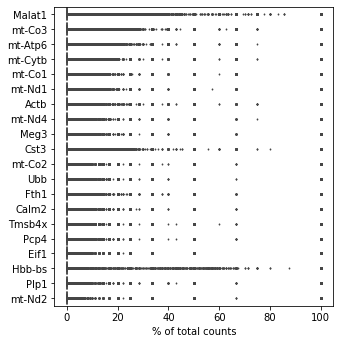

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

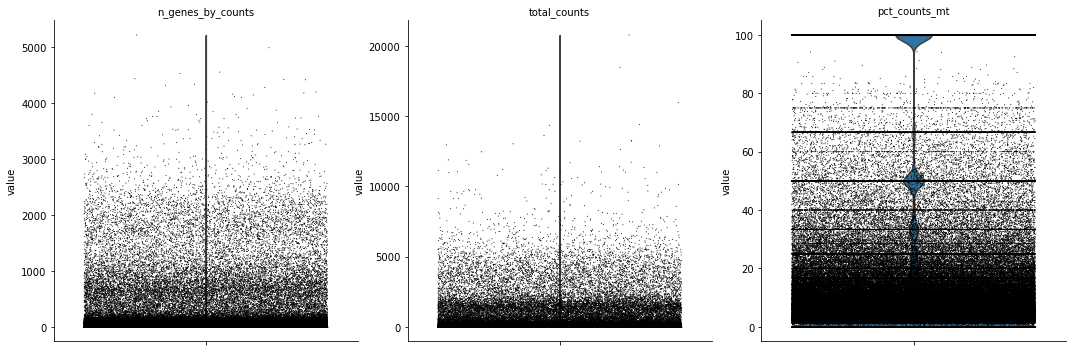

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

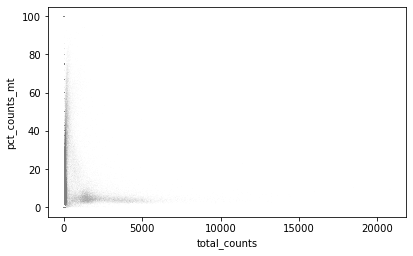

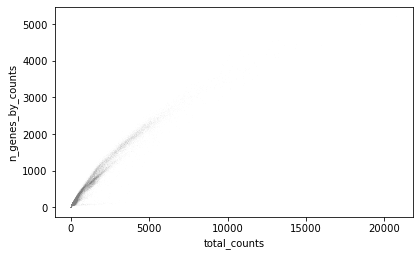

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
genes = cudf.Series(adata.var_names).str.upper()
print(genes)
from scipy import sparse

sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

0                  XKR4
1                GM1992
2               GM37381
3                   RP1
4                 SOX17
              ...      
31048        AC168977.1
31049        AC149090.1
31050    CAAA01118383.1
31051          VMN2R122
31052    CAAA01147332.1
Length: 31053, dtype: object


Verify the shape of the resulting sparse matrix:

In [32]:
sparse_gpu_array.shape

(1474560, 31053)

And the number of non-zero values in the matrix:

In [33]:
sparse_gpu_array.nnz

22682900

In [17]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

CPU times: user 280 ms, sys: 36 ms, total: 316 ms
Wall time: 314 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [18]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=min_cells_per_gene)

CPU times: user 191 ms, sys: 3.93 ms, total: 195 ms
Wall time: 193 ms


The size of our count matrix is now reduced.

In [19]:
sparse_gpu_array.shape

(20583, 20633)

In [20]:
import pandas as pd
df=genes.to_pandas()
for marker in markers:
    if not marker in df.values:
        print("%s is not included"%marker)
        markers.remove(marker)
        print("%s is removed from marker list"%marker)

DRD4 is not included
DRD4 is removed from marker list


In [21]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

CPU times: user 265 ms, sys: 36 ms, total: 301 ms
Wall time: 300 ms


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [22]:
%%time
mito_genes = genes.str.startswith(MITO_GENE_PREFIX)

n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 5.28 ms, sys: 18 µs, total: 5.3 ms
Wall time: 4.23 ms


And perform regression:

In [23]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array.tocsc(), n_counts, percent_mito)
del n_counts, percent_mito, mito_genes

CPU times: user 4min 7s, sys: 51.8 s, total: 4min 59s
Wall time: 4min 59s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [25]:
%%time
mean = sparse_gpu_array.mean(axis=0)
sparse_gpu_array -= mean
stddev = cp.sqrt(sparse_gpu_array.var(axis=0))
sparse_gpu_array /= stddev
sparse_gpu_array = sparse_gpu_array.clip(a_max=10)
del mean, stddev

CPU times: user 976 ms, sys: 76 ms, total: 1.05 s
Wall time: 1.06 s


In [ ]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 47641.403891801834


## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [26]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()
del sparse_gpu_array, genes

CPU times: user 283 ms, sys: 732 ms, total: 1.01 s
Wall time: 1.02 s


In [27]:
file_path="/temp/data/mouse_NAc/WT_NAc_adata.h5ad"
adata.write(file_path)
#adata = anndata.read_h5ad(file_path)

In [28]:
print(marker_genes_raw)

{'CX3CR1_raw': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32), 'CLDN5_raw': array([ 0.,  0., 16., ...,  0.,  0.,  0.], dtype=float32), 'GLUL_raw': array([ 0., 11.,  2., ...,  1.,  0.,  0.], dtype=float32), 'NDRG2_raw': array([0., 2., 4., ..., 2., 0., 0.], dtype=float32), 'PCDH15_raw': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'PLP1_raw': array([ 1., 50.,  0., ...,  0.,  0.,  0.], dtype=float32), 'MBP_raw': array([ 0., 27.,  0., ...,  0.,  0.,  1.], dtype=float32), 'SATB2_raw': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'SLC17A7_raw': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'SLC17A6_raw': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'GAD2_raw': array([3., 0., 0., ..., 0., 0., 0.], dtype=float32), 'GAD1_raw': array([3., 0., 0., ..., 0., 0., 0.], dtype=float32), 'SNAP25_raw': array([14.,  0.,  0., ...,  0.,  0.,  1.], dtype=float32), 'HTR1A_raw': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'HTR1B_raw': array([0., 0., 0., ..., 0., 0.,

In [29]:
%%time
GPCR_df=pd.DataFrame()
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()
    if   name[:-4] in GPCR_list:
        GPCR_df[name]=data.get()

CPU times: user 35.9 ms, sys: 3.83 ms, total: 39.8 ms
Wall time: 38.6 ms


In [30]:
GPCRdf_path="/temp/data/mouse_NAc/WT_NAc_scRNA_GPCR_raw_df.csv"
GPCR_df.to_csv(GPCRdf_path)
#GPCR_df=pd.read_csv(GPCRdf_path,index_col=0)

## Calculate response to antipsychotics in each cells

In [31]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
print(GPCR_adata.X.shape)
#GPCR_adata.obs=pd.DataFrame(GPCR_df.index)
#GPCR_adata.var=pd.DataFrame(GPCR_df.columns)

file_path="/temp/data/mouse_NAc/WT_NAc_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

(20583, 30)


In [32]:
file_path="/temp/data/mouse_NAc/WT_NAc_GPCR_adata.h5ad"
GPCR_adata = anndata.read_h5ad(file_path)

In [14]:
print(GPCR_df)
print(GPCR_df.columns)

       HTR1A_raw  HTR1B_raw  HTR1D_raw  HTR2A_raw  HTR2B_raw  HTR2C_raw  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            0.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
15754        0.0        0.0        0.0        0.0        0.0        0.0   
15755        0.0        0.0        0.0        0.0        0.0        0.0   
15756        0.0        0.0        0.0        0.0        0.0        0.0   
15757        0.0        0.0        0.0        0.0        0.0        2.0   
15758        0.0        0.0        0.0        0.0        0.0        0.0   

       HTR3A_raw  HTR4_raw  HTR5A_raw  HTR6_raw  ...  CHRM1_raw  CHRM2_raw  \
0            0.0     

In [ ]:
file_path="/temp/data/mouse_NAc/WT_NAc_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

TypeError: 0 of type <class 'int'> is an invalid key. Should be str.

Above error raised while writing key 'obs' of <class 'h5py._hl.files.File'> from /.

In [33]:
GPCR_adata.var.index

Index(['HTR1A_raw', 'HTR1B_raw', 'HTR1D_raw', 'HTR2A_raw', 'HTR2B_raw',
       'HTR2C_raw', 'HTR3A_raw', 'HTR4_raw', 'HTR5A_raw', 'HTR6_raw',
       'HTR7_raw', 'DRD1_raw', 'DRD2_raw', 'DRD3_raw', 'DRD5_raw', 'HRH1_raw',
       'HRH2_raw', 'HRH3_raw', 'CHRM1_raw', 'CHRM2_raw', 'CHRM3_raw',
       'CHRM4_raw', 'CHRM5_raw', 'ADRA1A_raw', 'ADRA1B_raw', 'ADRA2A_raw',
       'ADRA2B_raw', 'ADRA2C_raw', 'ADRB1_raw', 'ADRB2_raw'],
      dtype='object')

In [34]:
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
dir="/temp/data/mouse_NAc"
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)
GPCR_adata_norm_df.to_csv(os.path.join(dir,"GPCR_adata_norm_df.csv"))

In [35]:
#sc.pp.normalize_total(GPCR_adata,target_sum=1e4)
sc.pp.neighbors(GPCR_adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')


In [36]:

sc.tl.umap(GPCR_adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

In [37]:
%%time
sc.tl.louvain(GPCR_adata, flavor='rapids')
GPCR_adata.obs['leiden'] = rapids_scanpy_funcs.leiden(GPCR_adata)


CPU times: user 196 ms, sys: 8.01 ms, total: 204 ms
Wall time: 203 ms


In [38]:
print(GPCR_adata.obsm["X_umap"])
print(GPCR_adata.obs["louvain"])
print(GPCR_adata.obs["leiden"])

[[-2.5683594e+00  1.4791908e+00]
 [-5.9846191e+02  9.5517700e+02]
 [-8.8366797e+04  2.4429721e+04]
 ...
 [-3.7736042e+01  1.9528130e+01]
 [-5.4338299e+01  1.1773147e+02]
 [ 2.0603718e+01 -2.0772427e+01]]
0            0
1            1
2            2
3            3
4            4
         ...  
20578    20578
20579    20579
20580    20580
20581    20581
20582    20582
Name: louvain, Length: 20583, dtype: category
Categories (20583, object): ['0', '1', '2', '3', ..., '20579', '20580', '20581', '20582']
0            0
1            1
2            2
3            3
4            4
         ...  
20578    20578
20579    20579
20580    20580
20581    20581
20582    20582
Name: leiden, Length: 20583, dtype: category
Categories (20583, int64): [0, 1, 2, 3, ..., 20579, 20580, 20581, 20582]


In [88]:
#sc.pl.umap(GPCR_adata,color="leiden")

ValueError: Image size of 583x67292 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [39]:
norm_df=pd.DataFrame(GPCR_adata_norm)
norm_col=[str[:-4] for str in GPCR_df.columns]
#print(norm_col)
norm_df.columns=norm_col
print(norm_df)

       HTR1A  HTR1B  HTR1D  HTR2A  HTR2B        HTR2C  HTR3A  HTR4  HTR5A  \
0        0.0    0.0    0.0    0.0    0.0  6666.666504    0.0   0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
...      ...    ...    ...    ...    ...          ...    ...   ...    ...   
20578    0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
20579    0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
20580    0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
20581    0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   
20582    0.0    0.0    0.0    0.0    0.0     0.000000    0.0   0.0    0.0   

       HTR6  ...  CHRM3  CHRM4  CHRM5  ADRA1A  ADRA1B  ADRA2A  ADRA2B  ADRA

In [40]:
print(GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)])
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]

   receptor_name type
0         ADRA1A   Gq
1         ADRA1B   Gq
2         ADRA2A   Gi
3         ADRA2B   Gi
4         ADRA2C   Gi
5          ADRB1   Gs
6          ADRB2   Gs
7          CHRM1   Gq
8          CHRM2   Gi
9          CHRM3   Gq
10         CHRM4   Gi
11         CHRM5   Gq
12          DRD1   Gs
13          DRD2   Gi
14          DRD3   Gi
16          DRD5   Gs
17          HRH1   Gq
18          HRH2   Gs
19          HRH3   Gi
20         HTR1A   Gi
21         HTR1B   Gi
22         HTR1D   Gi
24         HTR2A   Gq
25         HTR2B   Gq
26         HTR2C   Gq
27          HTR4   Gs
28          HTR6   Gs
29          HTR7   Gs


In [41]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

#print(Gs)
#print(GPCR_adata_norm)
drug_list=D_R_mtx.index.to_list()
#print(drug_list)
#drug_receptor_mtx
cAMP_df=pd.DataFrame(columns=drug_list)
Ca_df=pd.DataFrame(columns=drug_list)
for drug in drug_list:
    Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
    Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
    Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
    cAMPmod=Gi_effect-Gs_effect #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下
    Camod=-Gq_effect #Gq阻害→Ca低下
    cAMP_df[drug]=cAMPmod
    Ca_df[drug]=Camod

In [42]:
cAMP_df.index=adata.obs_names
Ca_df.index=adata.obs_names
Ca_df=Ca_df+10**(-4)
for drug in drug_list:
    adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
    adata.obs['Ca_%s'%drug]=Ca_df[drug]

In [43]:
file_path="/temp/data/mouse_NAc/WT_NAc_adata.h5ad"
adata.write(file_path)

In [49]:
adata_cAMP=sc.AnnData(cAMP_df)

KeyboardInterrupt: 

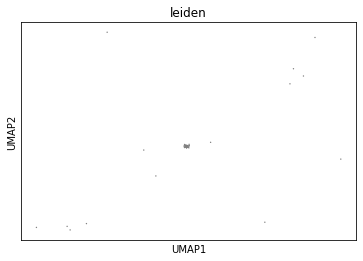

In [44]:
sc.pp.neighbors(adata_cAMP, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata_cAMP, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata_cAMP, flavor='rapids')
adata_cAMP.obs['leiden'] = rapids_scanpy_funcs.leiden(GPCR_adata)

sc.pl.umap(adata_cAMP,color="leiden")

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [44]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 3min 52s, sys: 1min 52s, total: 5min 44s
Wall time: 22.2 s


The UMAP function from Rapids is also integrated into Scanpy.

In [45]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 89.3 ms, sys: 104 ms, total: 193 ms
Wall time: 192 ms


Next, we use the Louvain algorithm for graph-based clustering.

In [46]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 35.9 ms, sys: 12 ms, total: 47.9 ms
Wall time: 47.1 ms


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

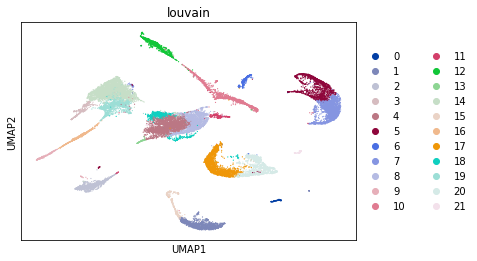

CPU times: user 409 ms, sys: 4.48 ms, total: 414 ms
Wall time: 417 ms


In [47]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [48]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 33.8 ms, sys: 7.8 ms, total: 41.6 ms
Wall time: 40.5 ms


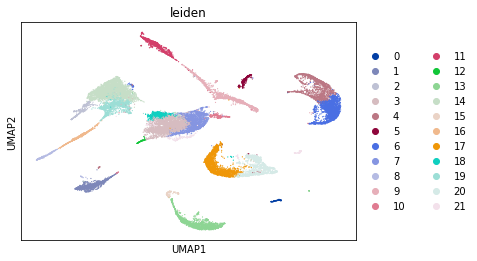

CPU times: user 418 ms, sys: 4.18 ms, total: 422 ms
Wall time: 418 ms


In [49]:
%%time
sc.pl.umap(adata, color=["leiden"])

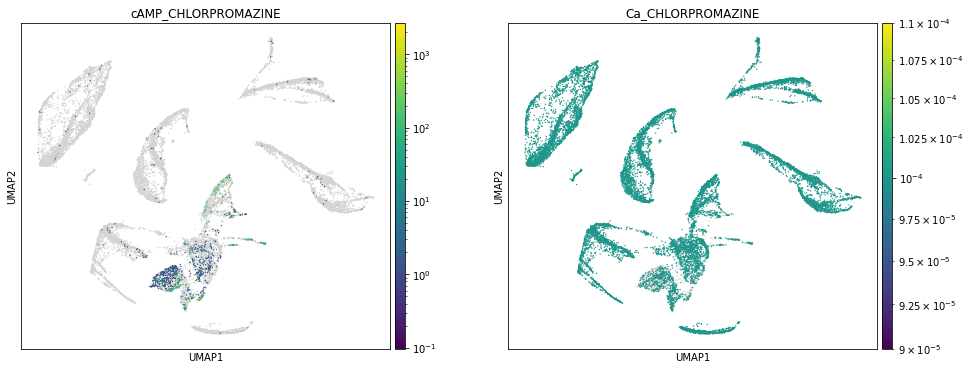

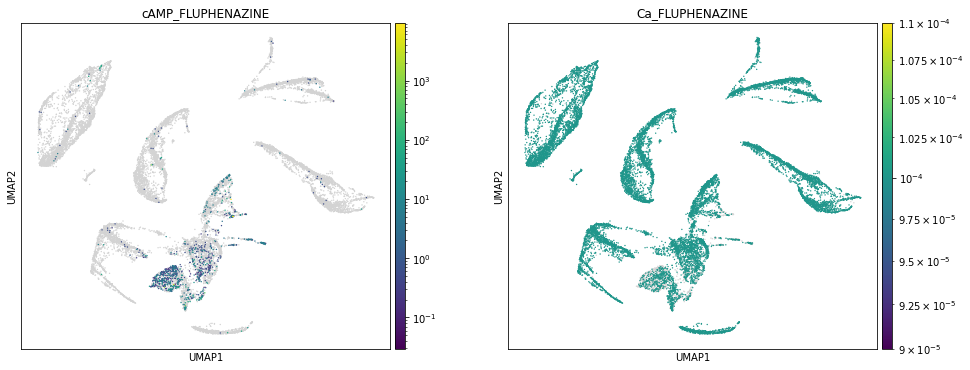

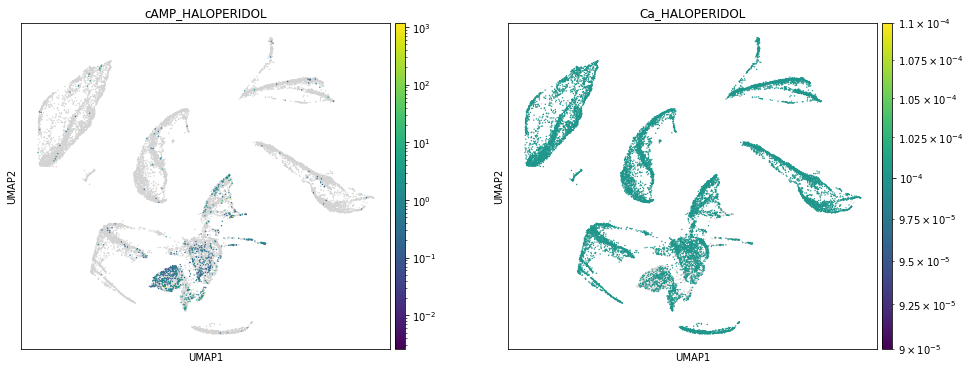

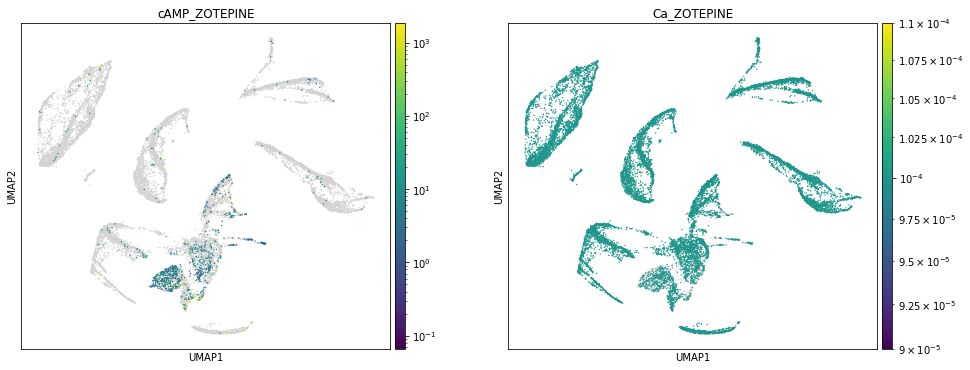

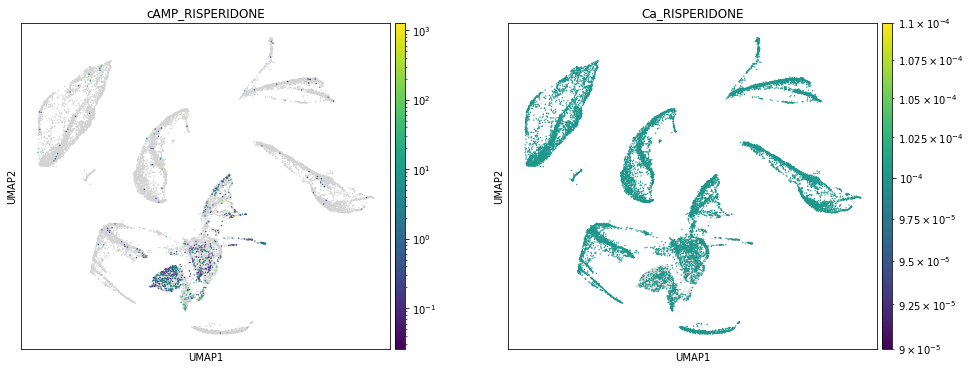

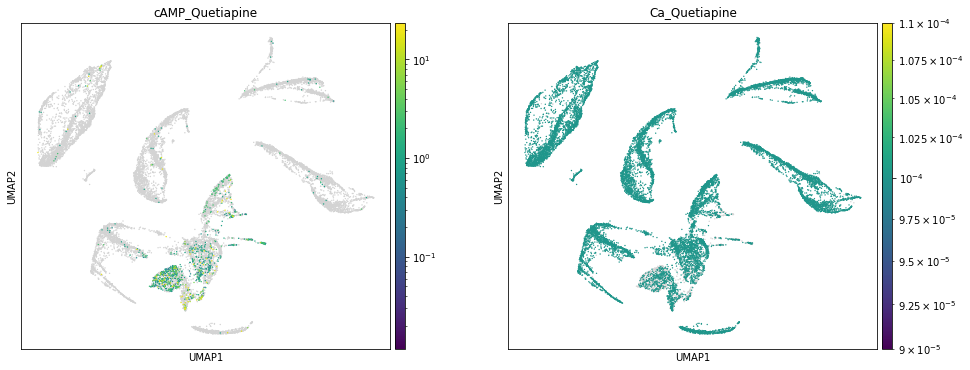

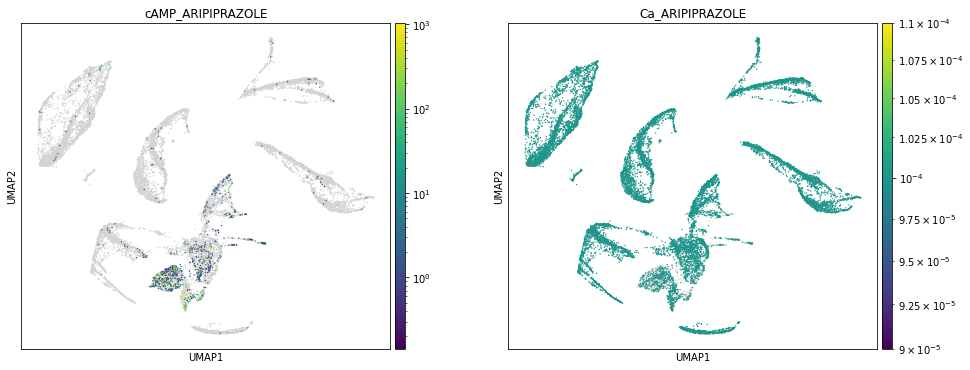

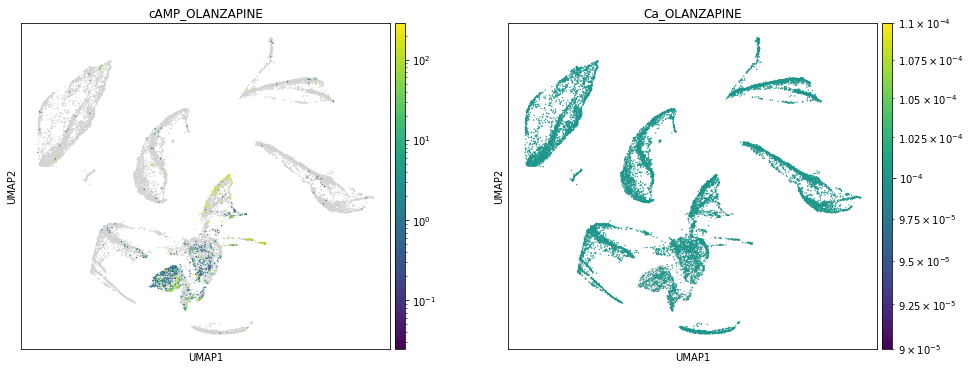

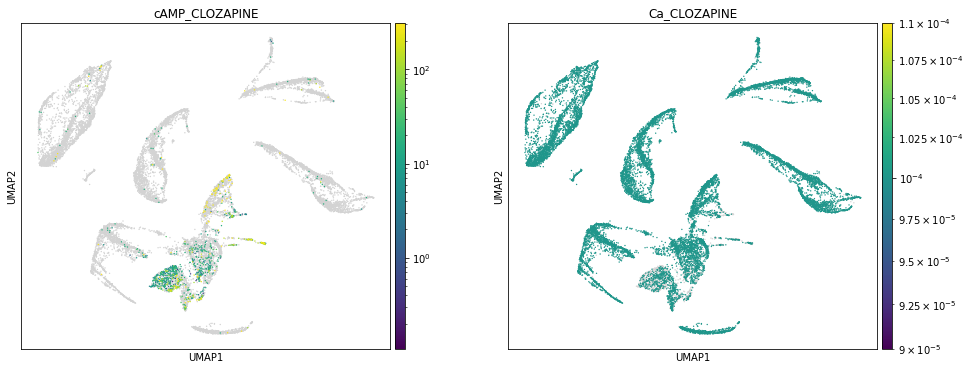

In [56]:
for drug in drug_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'wspace':0.2})
    ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=LogNorm(),ax=ax1, show=False)
    ax2_dict = sc.pl.umap(adata, color=["Ca_%s"%drug],norm=LogNorm(),ax=ax2, show=False)

And we can visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

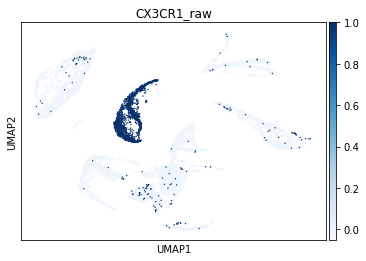

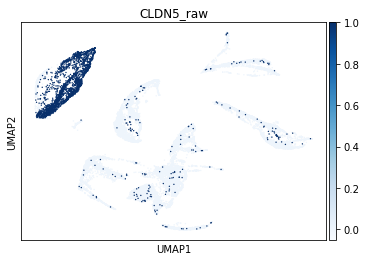

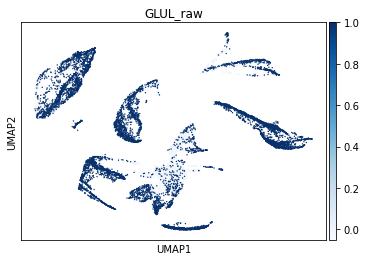

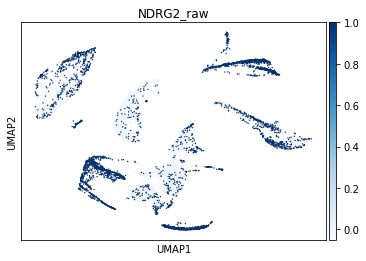

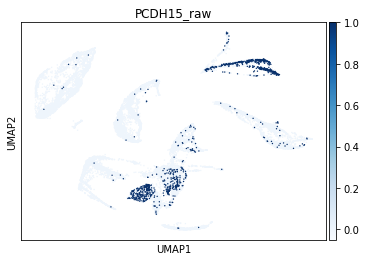

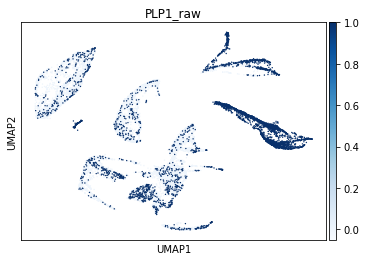

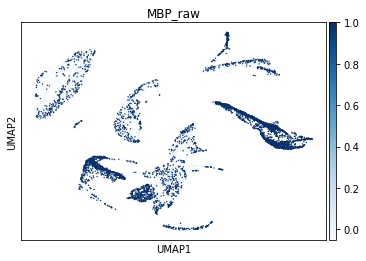

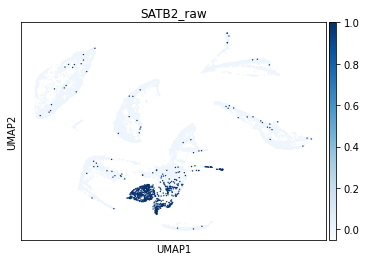

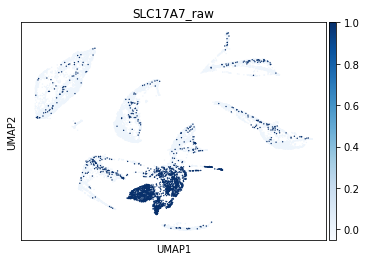

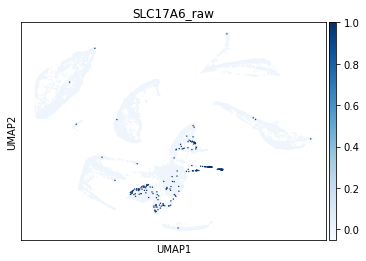

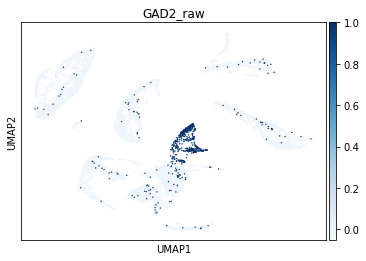

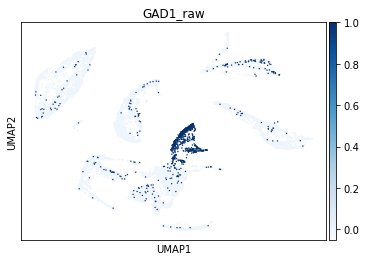

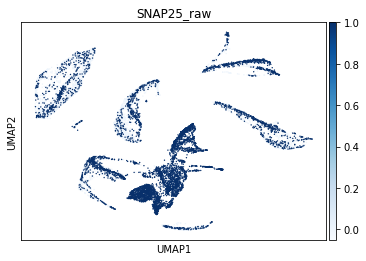

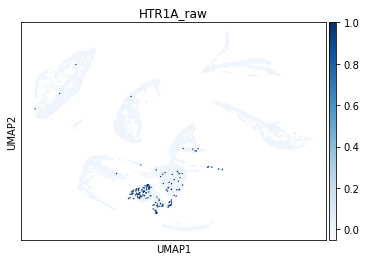

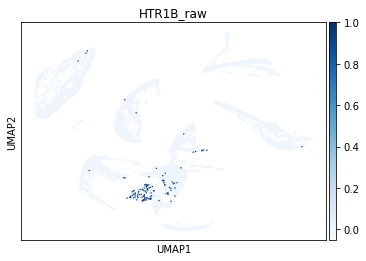

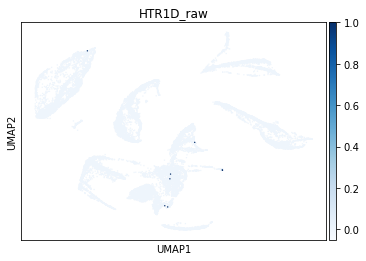

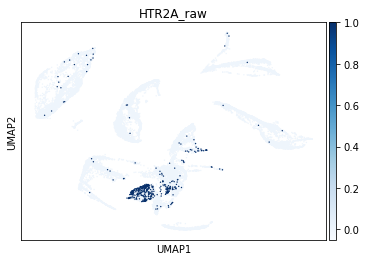

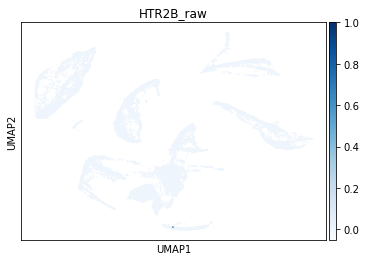

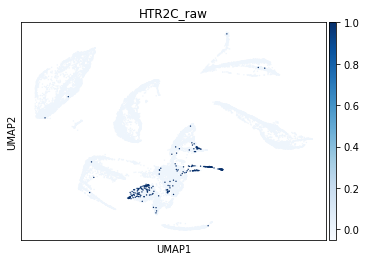

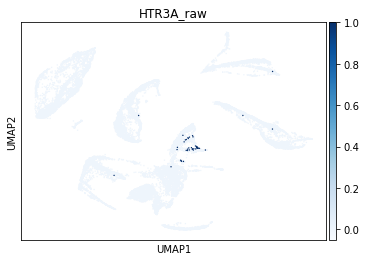

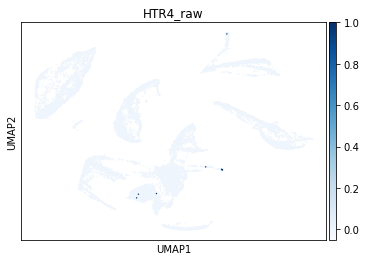

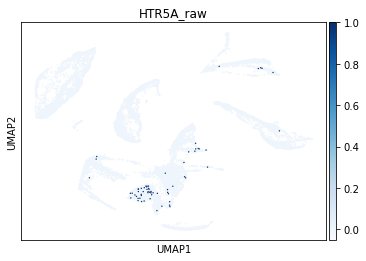

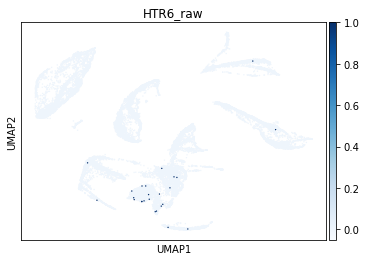

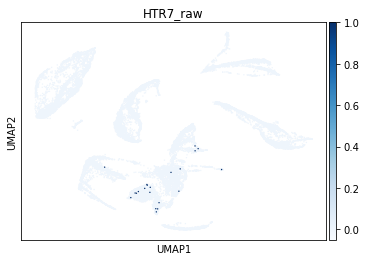

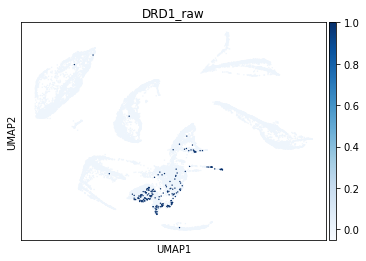

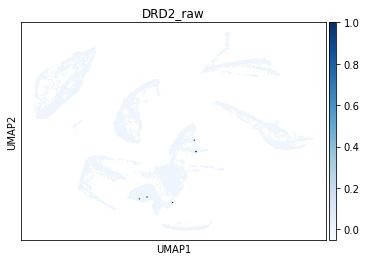

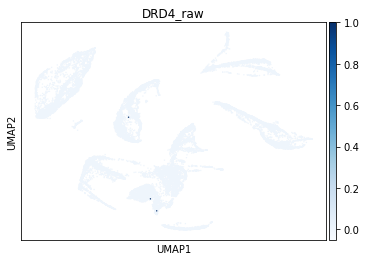

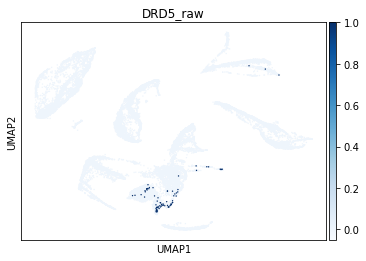

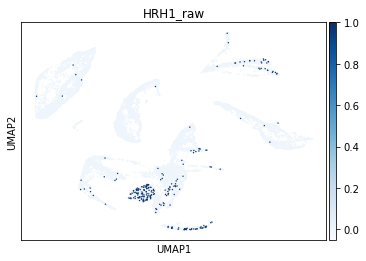

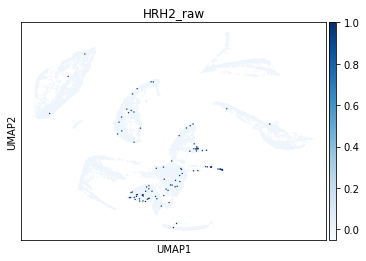

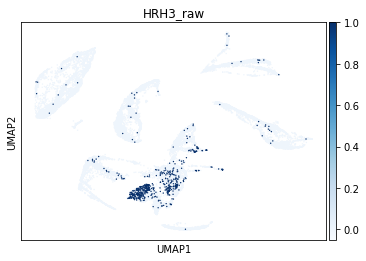

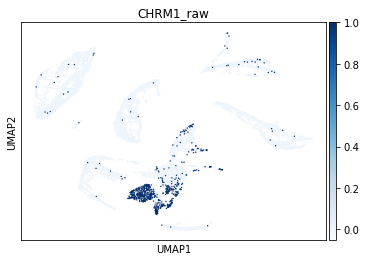

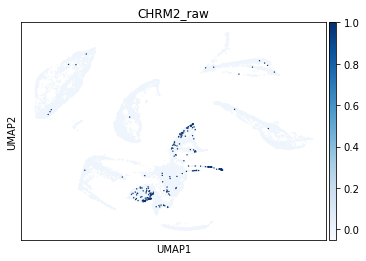

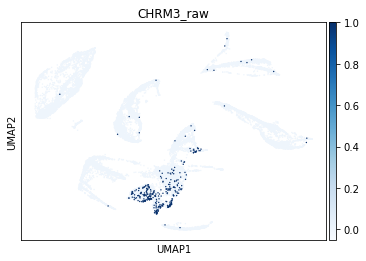

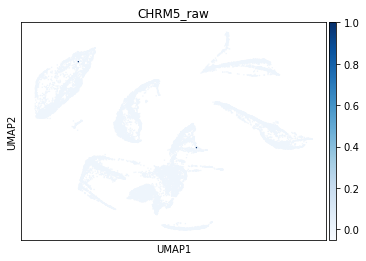

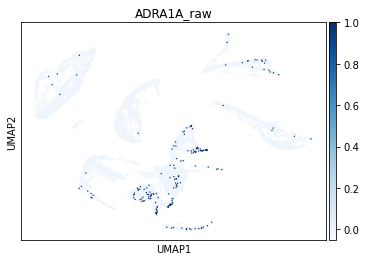

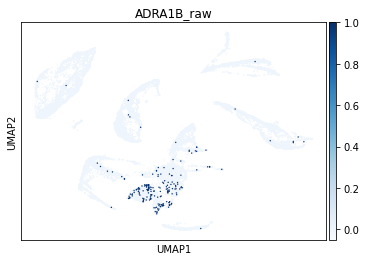

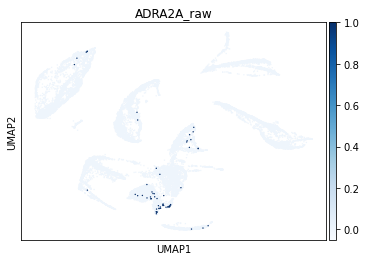

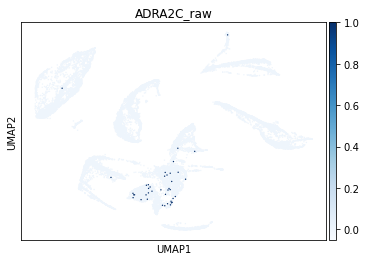

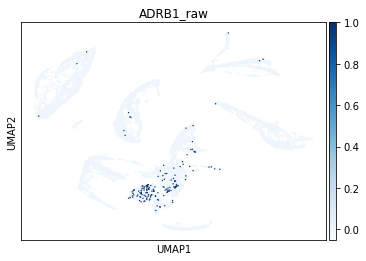

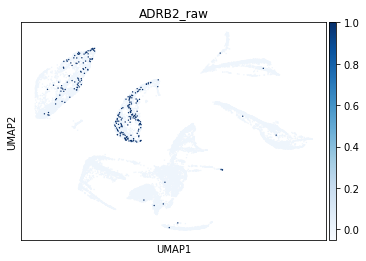

CPU times: user 5.32 s, sys: 88.2 ms, total: 5.4 s
Wall time: 5.36 s


In [57]:
%%time
#sc.pl.umap(adata, color=["Etv1_raw"], color_map="Reds", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Nos1_raw"], color_map="Reds", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Gad1_raw"], color_map="Blues", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Glp1r_raw"], color_map="Blues", vmax=1, vmin=-0.05)
for marker in markers:
    sc.pl.umap(adata, color=["%s_raw"%marker], color_map="Blues", vmax=1, vmin=-0.05)

In [59]:
dir="/temp/data/mouse_NAc"
h5_fname=os.path.join(dir,"mouse_WT_NAc_adata.h5ad")
adata.write(filename=h5_fname)

In [60]:
dir="/temp/data/mouse_NAc/"
h5_fname=os.path.join(dir,"mouse_WT_NAc_adata.h5ad")
adata=sc.read_h5ad(h5_fname)

In [61]:
adata.obs["is_clz_activated"]=np.zeros(len(adata.obs))
adata.obs["is_clz_activated"][adata.obs["cAMP_CLOZAPINE"]>10]=1
adata.obs["is_clz_activated"]=adata.obs["is_clz_activated"].astype("category")
print(sum(adata.obs["is_clz_activated"]))

1847.0


In [62]:
adata.obs["is_clz_inhibited"]=np.zeros(len(adata.obs))
adata.obs["is_clz_inhibited"][adata.obs["cAMP_CLOZAPINE"]<-10]=1
adata.obs["is_clz_inhibited"]=adata.obs["is_clz_inhibited"].astype("category")
print(sum(adata.obs["is_clz_inhibited"]))

1778.0


In [63]:
drug_list2=drug_list.copy()
drug_list2.remove("CLOZAPINE")
print(drug_list2)

for idx,drug in enumerate(drug_list2):
    #print(idx)
    if idx==0:
        cAMP_mean=adata.obs["cAMP_%s"%drug]
    else:
        cAMP_mean=cAMP_mean+adata.obs["cAMP_%s"%drug]
    #print(adata.obs["cAMP_%s"%drug])
cAMP_mean=cAMP_mean/len(drug_list2)
print(cAMP_mean)
adata.obs["cAMP_mean_other_than_czp"]=cAMP_mean
adata.obs["cAMP_clz_selectivity"]=adata.obs["cAMP_CLOZAPINE"]**2/cAMP_mean**2
print(sum(adata.obs["cAMP_clz_selectivity"]>1.5))

['CHLORPROMAZINE', 'FLUPHENAZINE', 'HALOPERIDOL', 'ZOTEPINE', 'RISPERIDONE', 'Quetiapine', 'ARIPIPRAZOLE', 'OLANZAPINE']
0           0.426422
1           0.000000
2           0.000000
3           0.000000
4           0.000000
            ...     
20578       0.000000
20579       0.000000
20580       0.000000
20581       0.000000
20582   -2170.459156
Length: 20583, dtype: float64
1038


In [64]:
selectivity_threshold=1.5
adata.obs["is_clz_selective"]=np.zeros(len(adata.obs))
adata.obs["is_clz_selective"][(adata.obs["cAMP_clz_selectivity"]>1.5)&(adata.obs["cAMP_CLOZAPINE"]>0)]=1
adata.obs["is_clz_selective"]=adata.obs["is_clz_selective"].astype("category")
print(sum(adata.obs["is_clz_selective"]))

720.0


In [79]:
print(cAMP_mean_other_than_czp)

[-15123.786149351981, -93078.91548872158, -4147.956769208519, -16231.908582844948, -60502.90483785582, -4022.733597306936, -91487.2778444587, -16301.926892259844]


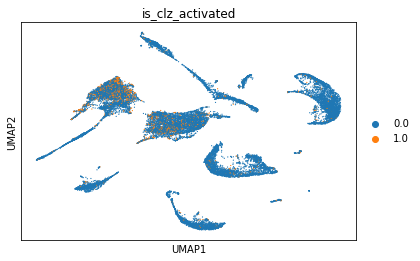

In [65]:
sc.pl.umap(adata, color=["is_clz_activated"])

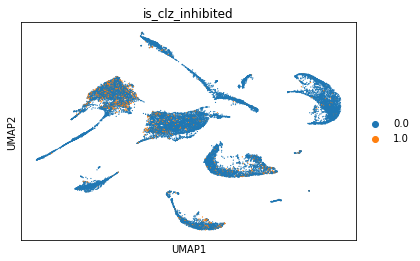

In [66]:
sc.pl.umap(adata, color=["is_clz_inhibited"])

In [16]:
print(adata.obs["is_clz_activated"].dtype)

category


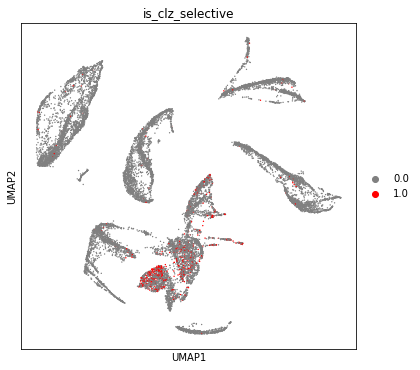

In [17]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6), gridspec_kw={'wspace':0.2})
sc.pl.umap(adata, color=["is_clz_selective"],ax=ax1,palette=["gray","red"])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.pdf",bbox_inches='tight')
fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.png",bbox_inches='tight')
plt.close()

In [67]:
sc.tl.rank_genes_groups(adata, 'is_clz_activated', method='wilcoxon')

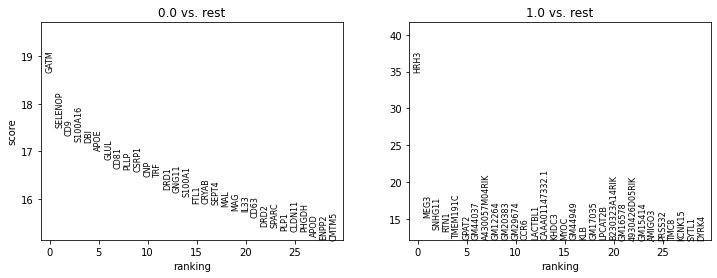

In [73]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False,save="clz_selective_over_olz_genes_mouse_NAc.pdf")

In [69]:
file_path="/temp/data/mouse_NAc/WT_NAc_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

In [70]:
file_path="/temp/data/mouse_NAc/WT_NAc_adata.h5ad"
adata.write(file_path)

In [52]:
adata.obs

cAMP_CHLORPROMAZINE  Ca_CHLORPROMAZINE  cAMP_FLUPHENAZINE  \
0                      0.0           0.000100                0.0   
1                      0.0           0.000100                0.0   
2                      0.0           0.000100                0.0   
3                      0.0           0.000100                0.0   
4                      0.0           0.000100                0.0   
...                    ...                ...                ...   
15754                  0.0           0.000100                0.0   
15755                  0.0           0.000100                0.0   
15756                 -1.0           0.000100               -1.0   
15757                  0.0        -417.525185                0.0   
15758                  0.0           0.000100                0.0   

       Ca_FLUPHENAZINE  cAMP_HALOPERIDOL  Ca_HALOPERIDOL  cAMP_ZOTEPINE  \
0             0.000100          0.000000        0.000100       0.000000   
1             0.000100          0.000000        0.000100       0.000000   
2             0.000100          0.000000        0.000100       0.000000   
3             0.000100          0.000000        0.000100       0.000000   
4             0.000100          0.000000        0.000100       0.000000   
...                ...               ...             ...            ...   
15754         0.000100          0.000000        0.000100       0.000000   
15755         0.000100          0.000000        0.000100       0.000000   
15756         0.000100         -1.333333        0.000100      -1.626016   
15757       -10.708848          0.000000       -1.689114       0.000000   
15758         0.000100          0.000000        0.000100       0.000000   

       Ca_ZOTEPINE  cAMP_RISPERIDONE  Ca_RISPERIDONE  ...  cAMP_OLANZAPINE  \
0         0.000100          0.000000        0.000100  ...         0.000000   
1         0.000100          0.000000        0.000100  ...         0.000000   
2         0.000100          0.000000        0.000100  ...         0.000000   
3         0.000100          0.000000        0.000100  ...         0.000000   
4         0.000100          0.000000        0.000100  ...         0.000000   
...            ...               ...             ...  ...              ...   
15754     0.000100          0.000000        0.000100  ...         0.000000   
15755     0.000100          0.000000        0.000100  ...         0.000000   
15756     0.000100         -1.333333        0.000100  ...        -1.333333   
15757 -2966.471759          0.000000     -302.795233  ...         0.000000   
15758     0.000100          0.000000        0.000100  ...         0.000000   

       Ca_OLANZAPINE  cAMP_CLOZAPINE  Ca_CLOZAPINE  louvain  \
0           0.000100        0.000000      0.000100        4   
1           0.000100        0.000000      0.000100        0   
2           0.000100        0.000000      0.000100        0   
3           0.000100        0.000000      0.000100        0   
4           0.000100        0.000000      0.000100        1   
...              ...             ...           ...      ...   
15754       0.000100        0.000000      0.000100       23   
15755       0.000100        0.000000      0.000100       21   
15756       0.000100       -1.716738      0.000100       13   
15757    -645.886212        0.000000   -301.493937       14   
15758       0.000100        0.000000      0.000100       25   

       cAMP_mean_other_than_czp  cAMP_clz_selectivity  is_clz_selective  \
0                       0.00000                   NaN               0.0   
1                       0.00000                   NaN               0.0   
2                       0.00000                   NaN               0.0   
3                       0.00000                   NaN               0.0   
4                       0.00000                   NaN               0.0   
...                         ...                   ...               ...   
15754                   0.00000                   NaN               0.

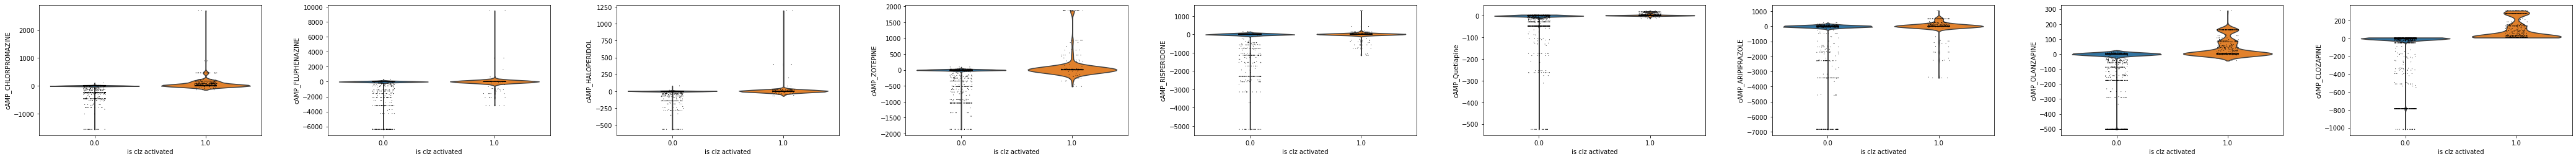

CPU times: user 2.63 s, sys: 9.31 s, total: 11.9 s
Wall time: 1.45 s


In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_activated')

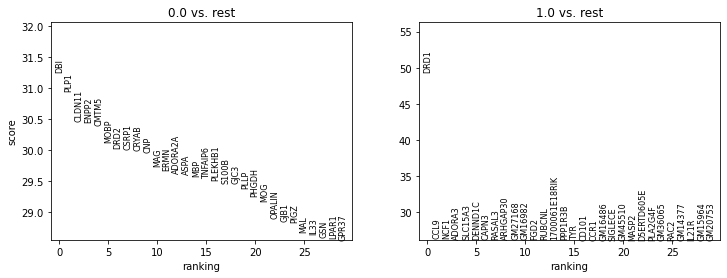

In [74]:
sc.tl.rank_genes_groups(adata, 'is_clz_inhibited', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

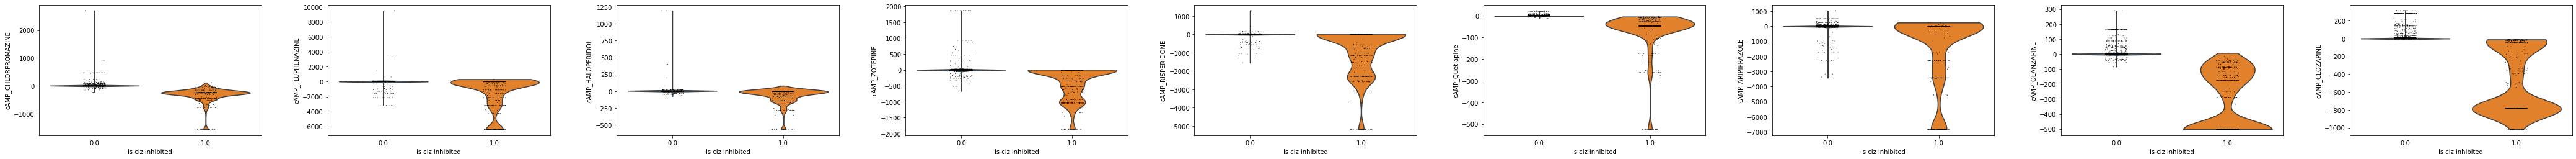

CPU times: user 2.45 s, sys: 9.34 s, total: 11.8 s
Wall time: 1.4 s


In [74]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_inhibited')

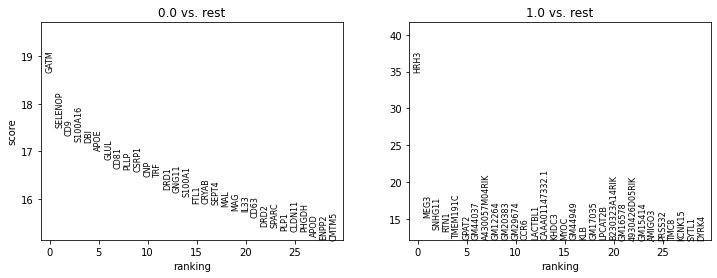

In [75]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

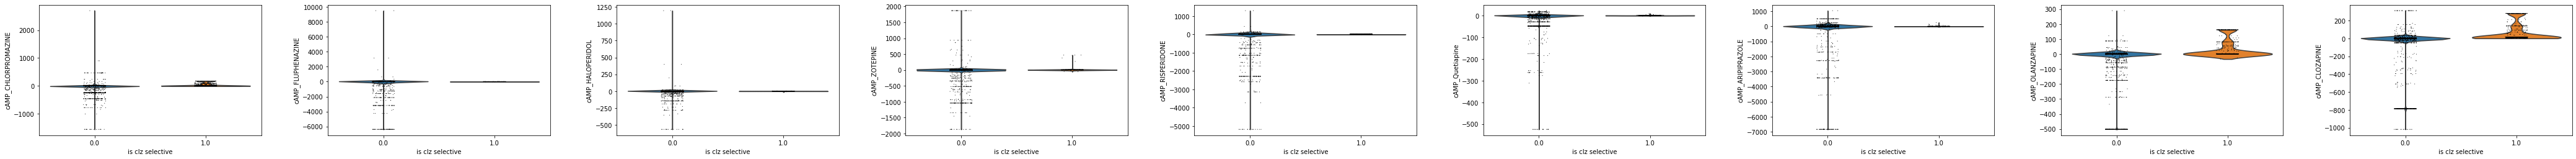

CPU times: user 2.56 s, sys: 9.27 s, total: 11.8 s
Wall time: 1.38 s


In [114]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective')

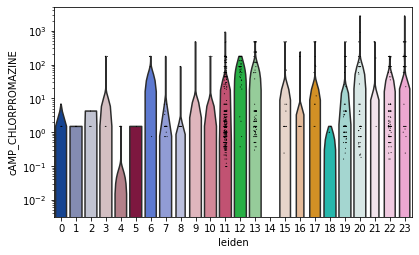

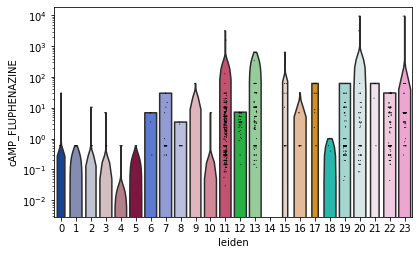

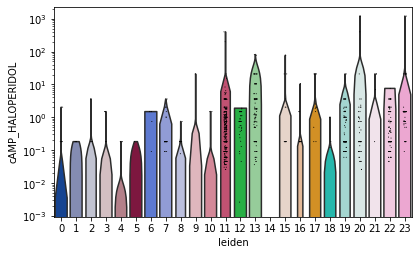

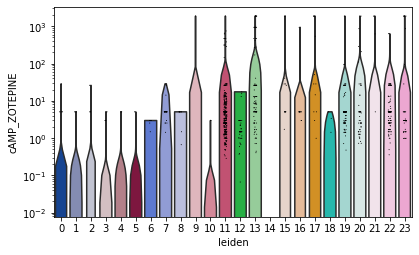

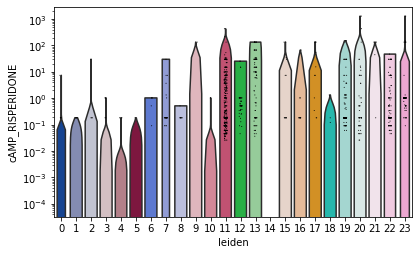

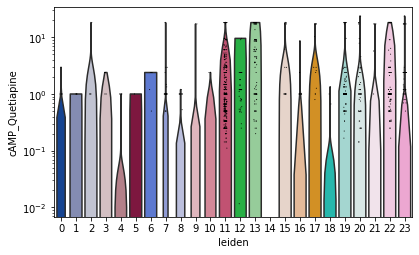

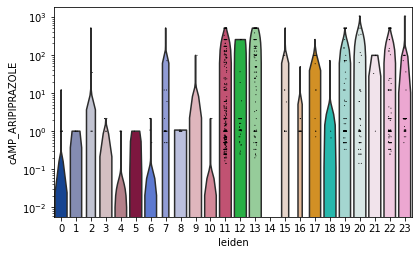

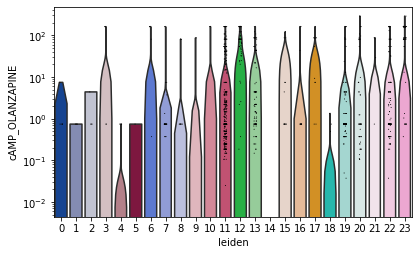

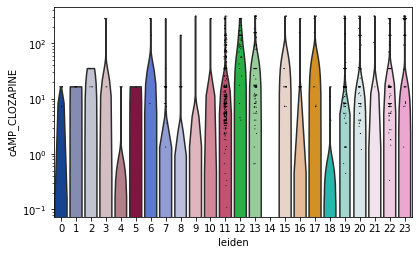

CPU times: user 5.59 s, sys: 23.6 ms, total: 5.61 s
Wall time: 5.6 s


In [117]:
%%time
for drug in drug_list:
    sc.pl.violin(adata, "cAMP_%s"%drug, groupby='leiden',stripplot=True,log=True)